In [1]:
import os
import pandas as pd
import datetime as dt
import xarray as xr
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/Users/acheung/TC_RI_P1/scripts/Useful Functions/')
from distance import distance_calculator
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from scipy.interpolate import RegularGridInterpolator
import multiprocessing
from plot_imerg_for_mrms import imerg_for_mrms
import geopandas as gpd
import shapely.geometry as geom
from shapely import Point
from metpy.interpolate import interpolate_to_points


In [2]:
data_type = "MRMS"
SHIPS = pd.read_csv('/Users/acheung/data/SHIPS/all_SHIPs_data_combined_north_atlantic.csv')
SHIPS = SHIPS.where(pd.to_datetime(SHIPS['Time']) >= dt.datetime(2015,5,6)).dropna()
near_land_cases = SHIPS.where(SHIPS['DTL'] < 100).dropna()


In [ ]:
def min_distance(point, lines):
    return lines.distance(point).min()
dist_list = []
for ships_inds in near_land_cases.index:

    coastline = gpd.read_file('/Users/acheung/data/Shapefiles/tl_2024_us_coastline.shp')
    coastline = coastline.where(
        (coastline['NAME'] == 'Gulf') | (coastline['NAME'] == 'Atlantic')).dropna()
    
    PR_inds = list([271,277,list(np.arange(281,304)),list(np.arange(920,935))])

    def flatten(test_list):
        if isinstance(test_list, list):
            temp = []
            for ele in test_list:
                temp.extend(flatten(ele))
            return temp
        else:
            return [test_list]

    flattened_pr = flatten(PR_inds)
    
    coastline_no_pr = coastline.drop(flattened_pr)

    # coastline = gpd.clip(gpd.read_file('ne_10m_coastline.shp'), us).to_crs('EPSG:3087')
    coastline_no_pr = coastline_no_pr.to_crs('EPSG:3087')
    points_df = gpd.GeoDataFrame({
        'geometry': [
            Point(360-SHIPS['LON'].loc[ships_inds], SHIPS['LAT'].loc[ships_inds])]}, crs='EPSG:4326')
    points_df = points_df.to_crs('EPSG:3087') # https://epsg.io/3087

    points_df['min_dist_to_coast'] = points_df.geometry.apply(min_distance, args=(coastline_no_pr,))
    print((points_df['min_dist_to_coast']/1000)[0])
    dist = (points_df['min_dist_to_coast']/1000)[0]
    dist_list.append(dist)
distances_to_us_coast = pd.DataFrame(dist_list,index = near_land_cases.index)
distances_to_us_coast.to_csv('/Users/acheung/data/intermediates/dists_to_us_coast.csv')

82.37639772443805
33.32433623701068
13.582256140478496
51.05959760204954
84.4363871748126
122.30199559137101
124.06220069894181
0.33637224771209717
55.18315849078171
1.895834820740922
93.2169683880753
213.80270998713593
322.0656347708664
403.33758563317383
476.94119851730096
529.6824025862046
574.4494840231555
2325.4061700549337
2242.1695705745096
2118.7793693247354
1812.8867434581637
1642.6969201369607
1479.372962928365
11.757227094609982
48.27609135346683
18.3045100618585
39.30425097298249


In [ ]:
distances_to_us_coast = pd.read_csv('/Users/acheung/data/intermediates/dists_to_us_coast.csv')
distances_to_us_coast = pd.read_csv('/Users/acheung/data/intermediates/dists_to_us_coast.csv')['0']
distances_to_us_coast.index = near_land_cases.index

In [ ]:
near_us_coast_cases = near_land_cases.loc[distances_to_us_coast.where(distances_to_us_coast < 150).dropna().index]
atcf_ids = near_us_coast_cases['Storm_ID'].unique()

current_near_land_case = near_us_coast_cases.where(near_land_cases['Storm_ID'] == atcf_ids[34]).dropna()
current_storm_name = str(current_near_land_case['Name'].unique()[0])
current_storm_ID = str(current_near_land_case['Storm_ID'].unique()[0])

desired_lat = current_near_land_case['LAT'].mean()
desired_lon = 360-current_near_land_case['LON'].mean()

start_str = current_near_land_case['Time'].iloc[0]
end_str = str(pd.to_datetime(current_near_land_case['Time'].iloc[-1]) + dt.timedelta(hours=24)) # Add 24 hours after best-track ends!

times_pd = pd.date_range(start=start_str,end=end_str, freq='1h')
times_pd = times_pd[0:-1]


In [ ]:
filepaths = []
for i in times_pd: # Download all the desired IMERG Images
    # If IMERG file does not exist, download it
    
    year = i.strftime('%Y')
    month = i.strftime('%m')
    day =  i.strftime('%d')
    hour = i.strftime('%H')
    
    if (times_pd[0]).to_pydatetime() >= dt.datetime(2020,10,15): # Switch to dual-pol led to file directory change! Keep this in mind!
        data_file_path = '/Users/acheung/data/MRMS/'+year+'/'+month +'/'+ day+\
            '/MultiSensor_QPE_01H_Pass2_00.00_' + year+month+day+'-'+hour+'0000.grib2'
        url_desired = "https://mtarchive.geol.iastate.edu/"+year+"/"+month+"/"+day+"/mrms/ncep/MultiSensor_QPE_01H_Pass2/"\
            + 'MultiSensor_QPE_01H_Pass2_00.00_' + year+month+day+'-'+hour+'0000.grib2.gz'
        
    elif (times_pd[0]).to_pydatetime() < dt.datetime(2020,10,15): # Switch to dual-pol led to file directory change! Keep this in mind!
        data_file_path = '/Users/acheung/data/MRMS/'+year+'/'+month +'/'+ day+\
            '/GaugeCorr_QPE_01H_00.00_' + year+month+day+'-'+hour+'0000.grib2'
        url_desired = "https://mtarchive.geol.iastate.edu/"+year+"/"+month+"/"+day+"/mrms/ncep/GaugeCorr_QPE_01H/"\
            + 'GaugeCorr_QPE_01H_00.00_' + year+month+day+'-'+hour+'0000.grib2.gz'

# If day directory does not exist, make day directory
    if os.path.exists('/Users/acheung/data/MRMS/'+year) == False:
        os.mkdir('/Users/acheung/data/MRMS/'+year)

    if os.path.exists('/Users/acheung/data/MRMS/'+year+'/'+month) == False:
        os.mkdir('/Users/acheung/data/MRMS/'+year+'/'+month)

    if os.path.exists('/Users/acheung/data/MRMS/'+year+'/'+month +'/'+ day) == False:
        os.mkdir('/Users/acheung/data/MRMS/'+year+'/'+month +'/'+ day)

    if os.path.exists(data_file_path) == False:

        os.chdir('/Users/acheung/data/MRMS/'+year+'/'+month +'/'+ day)

        os.system('wget --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies --keep-session-cookies '
                  + url_desired)
        
        os.system('gzip -d '+data_file_path+'.gz')
    filepaths.append(data_file_path)


In [ ]:
# Use multiprocessing to slice MRMS or Stage IV Data (speeds up process significantly)

def slicing_file(case_loop,ground_total_precip,filepaths,desired_lon,desired_lat,sliced_lon_arr,sliced_lat_arr):
    import numpy as np
    import xarray as xr
    import sys
    sys.path.insert(0, '/Users/acheung/TC_RI_P1/scripts/Useful Functions/')
    from distance import distance_calculator
    
    ground_based_data = xr.open_dataset(filepaths[case_loop], engine="cfgrib")['unknown']
    x, y = np.float32(np.meshgrid(ground_based_data['longitude'], ground_based_data['latitude']))


    # Find index closest to interpolated best-track center or 2-km radar center
    distance_arr = distance_calculator(x,y,(desired_lon,desired_lat))

    abs_dist_arr = (abs(distance_arr))

    min_dist_ind = np.where(abs_dist_arr == np.nanmin(abs_dist_arr))

    # Slice arrays to within 30 indices of desired center

    sliced_lon_grid = x[min_dist_ind[0][0]-400:min_dist_ind[0][0]+400,min_dist_ind[1][0]-400:min_dist_ind[1][0]+400]

    sliced_lat_grid = y[min_dist_ind[0][0]-400:min_dist_ind[0][0]+400,min_dist_ind[1][0]-400:min_dist_ind[1][0]+400]

    sliced_ground_based_data = ground_based_data[min_dist_ind[0][0]-400:min_dist_ind[0][0]+400,min_dist_ind[1][0]-400:min_dist_ind[1][0]+400]
    ground_total_precip[case_loop] = sliced_ground_based_data.values
    
    if case_loop == 0: # Only grab lat/lon array once for plotting later
        sliced_lat_arr[case_loop] = sliced_ground_based_data['latitude']
        sliced_lon_arr[case_loop] = sliced_ground_based_data['longitude']

if __name__ == "__main__": # Run multiprocesses
    manager = multiprocessing.Manager()
    ground_total_precip = manager.dict()
    sliced_lat_arr = manager.dict()
    sliced_lon_arr = manager.dict()
    jobs = []
    for i in range(len(filepaths)):
        p = multiprocessing.Process(target=slicing_file, args=(i, ground_total_precip,filepaths,desired_lon,desired_lat,
                                                               sliced_lon_arr,sliced_lat_arr))
        jobs.append(p)
        p.start()

    for proc in jobs:
        proc.join()
        
# Sum up precipitation (MRMS data is hourly QPE)
summed_precip = np.sum(np.asarray(ground_total_precip.values()),axis=0)

Text(0.5, 1.0, 'Current Storm: DANNY (AL042021)\nMRMS Precipitation: \n Start: 2021-06-28 18:00:00; End: 2021-06-30 00:00:00')

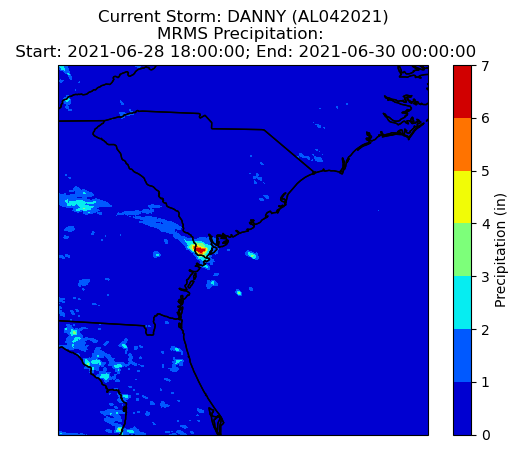

In [7]:
# Plot MRMS Data before interpolation
ax=plt.axes(projection=ccrs.PlateCarree())
precip_plot = ax.contourf(sliced_lon_arr[0],sliced_lat_arr[0],
                          summed_precip/25.4,transform = ccrs.PlateCarree(),cmap='jet',
                         levels=np.arange(0,np.ceil((summed_precip/25.4).max()),1))
plt.colorbar(precip_plot,label='Precipitation (in)')
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.COASTLINE)
ax.set_title('Current Storm: ' + current_storm_name + ' (' + current_storm_ID + ')\n'+data_type+
             ' Precipitation: \n Start: ' + start_str + '; End: ' + end_str)

In [8]:
# Open IMERG Data Processed From Other Notebook
imerg_for_mrms(start_str,end_str,desired_lon,desired_lat)

imerg_precip_data = xr.open_dataset('/Users/acheung/data/intermediates/start = '+start_str+', end = '+end_str+' imerg.nc')

converted_long = sliced_lon_arr[0] - 360

x_grid, y_grid = np.float32(np.meshgrid(converted_long, sliced_lat_arr[0]))

# Interpolate MRMS data to IMERG Grid Resolution
interpolater = RegularGridInterpolator((sliced_lat_arr[0].values,converted_long.values),
                                              summed_precip,bounds_error=False)

interpolated_ground_data = interpolater((imerg_precip_data['lat'].values, imerg_precip_data['lon'].values))

/Users/acheung/data/IMERG/2021/179/3B-HHR.MS.MRG.3IMERG.20210628-S180000-E182959.1080.V07B.HDF5
/Users/acheung/data/IMERG/2021/179/3B-HHR.MS.MRG.3IMERG.20210628-S183000-E185959.1110.V07B.HDF5
/Users/acheung/data/IMERG/2021/179/3B-HHR.MS.MRG.3IMERG.20210628-S190000-E192959.1140.V07B.HDF5
/Users/acheung/data/IMERG/2021/179/3B-HHR.MS.MRG.3IMERG.20210628-S193000-E195959.1170.V07B.HDF5

/Users/acheung/data/IMERG/2021/179/3B-HHR.MS.MRG.3IMERG.20210628-S200000-E202959.1200.V07B.HDF5/Users/acheung/data/IMERG/2021/179/3B-HHR.MS.MRG.3IMERG.20210628-S203000-E205959.1230.V07B.HDF5
/Users/acheung/data/IMERG/2021/179/3B-HHR.MS.MRG.3IMERG.20210628-S210000-E212959.1260.V07B.HDF5
/Users/acheung/data/IMERG/2021/179/3B-HHR.MS.MRG.3IMERG.20210628-S213000-E215959.1290.V07B.HDF5
/Users/acheung/data/IMERG/2021/179/3B-HHR.MS.MRG.3IMERG.20210628-S220000-E222959.1320.V07B.HDF5
/Users/acheung/data/IMERG/2021/179/3B-HHR.MS.MRG.3IMERG.20210628-S223000-E225959.1350.V07B.HDF5
/Users/acheung/data/IMERG/2021/179/3B-HH

In [9]:
x,y = np.meshgrid(sliced_lon_arr[0].values,sliced_lat_arr[0])
flat_x = x.flatten()
flat_y = y.flatten()

data_points = np.vstack((flat_x,flat_y)).transpose()
flat_precip = summed_precip.flatten()


Text(0.5, 1.0, 'Interpolated MRMS Precipitation: \n Start: 2021-06-28 18:00:00; End: 2021-06-30 00:00:00')

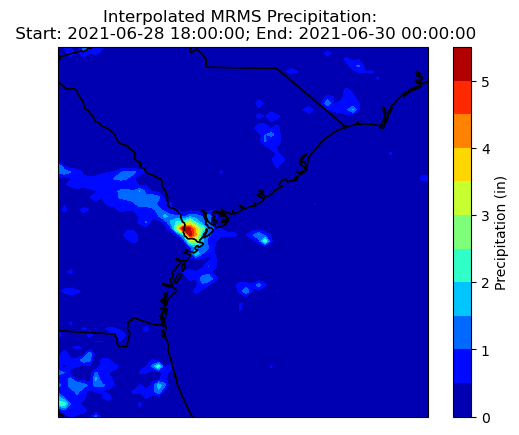

In [10]:
# Plot MRMS Data at IMERG Resolution
ax=plt.axes(projection=ccrs.PlateCarree())

if np.ceil((interpolated_ground_data/25.4).max()) < 10:
    map_interval = 0.5
elif np.ceil((interpolated_ground_data/25.4).max()) >= 10:
    map_interval = 1
interp_plot = ax.contourf(imerg_precip_data['lon'].values,imerg_precip_data['lat'].values,interpolated_ground_data/25.4,cmap='jet',
                         levels=np.arange(0,np.ceil((interpolated_ground_data/25.4).max()),map_interval),transform = ccrs.PlateCarree())
plt.colorbar(interp_plot,label='Precipitation (in)')
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.COASTLINE)
ax.set_title('Interpolated '+ data_type +' Precipitation: \n Start: ' + start_str + '; End: ' + end_str)


Text(0.5, 1.0, 'IMERG Precipitation: \n Start: 2021-06-28 18:00:00; End: 2021-06-30 00:00:00')

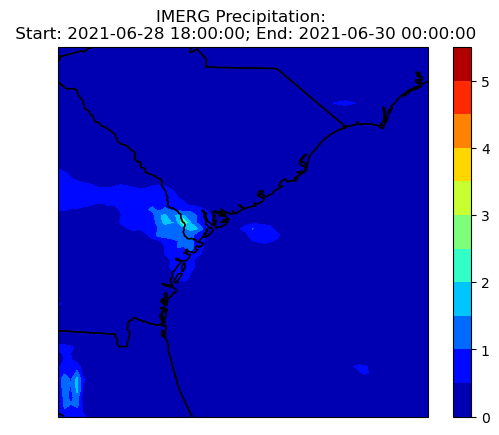

In [11]:
# Plot IMERG Precipitation
ax=plt.axes(projection=ccrs.PlateCarree())

interp_plot = ax.contourf(imerg_precip_data['lon'].values,imerg_precip_data['lat'].values,
                          imerg_precip_data['__xarray_dataarray_variable__']/25.4,cmap='jet',
                         levels=np.arange(0,np.ceil((interpolated_ground_data/25.4).max()),map_interval),transform = ccrs.PlateCarree())
plt.colorbar(interp_plot)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.COASTLINE)
ax.set_title('IMERG Precipitation: \n Start: ' + start_str + '; End: ' + end_str)

Text(0.5, 1.0, 'MRMS and IMERG Precipitation Difference \n Start: 2021-06-28 18:00:00; End: 2021-06-30 00:00:00')

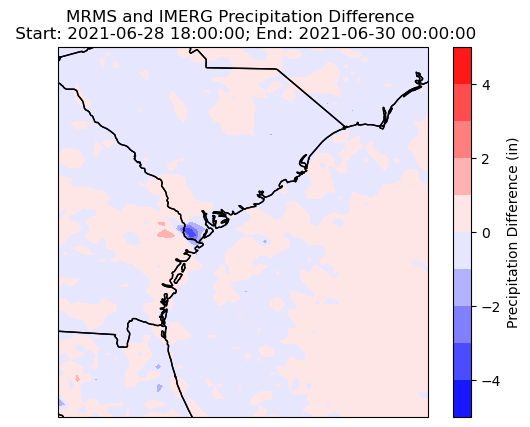

In [12]:
# Plot Difference Plot between MRMS and IMERG
ax=plt.axes(projection=ccrs.PlateCarree())

interp_plot = ax.contourf(imerg_precip_data['lon'].values,imerg_precip_data['lat'].values,
                          (imerg_precip_data['__xarray_dataarray_variable__']/25.4)-(interpolated_ground_data/25.4),cmap='bwr',
                         levels=np.arange(-int(np.ceil(abs(
                             (imerg_precip_data['__xarray_dataarray_variable__']/25.4)-(
                                 interpolated_ground_data/25.4)).max())),int(np.ceil(
                             abs((imerg_precip_data['__xarray_dataarray_variable__']/25.4)-(
                                 interpolated_ground_data/25.4)).max()))+0.1,1),transform = ccrs.PlateCarree())
plt.colorbar(interp_plot,label='Precipitation Difference (in)')
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.COASTLINE)
ax.set_title(data_type + ' and IMERG Precipitation Difference' + ' \n Start: ' + start_str + '; End: ' + end_str)

In [13]:
from metpy.interpolate import interpolate_to_grid

In [51]:
x[0:50]

array([[275.89499869, 275.90499869, 275.91499869, ..., 283.86499846,
        283.87499846, 283.88499846],
       [275.89499869, 275.90499869, 275.91499869, ..., 283.86499846,
        283.87499846, 283.88499846],
       [275.89499869, 275.90499869, 275.91499869, ..., 283.86499846,
        283.87499846, 283.88499846],
       ...,
       [275.89499869, 275.90499869, 275.91499869, ..., 283.86499846,
        283.87499846, 283.88499846],
       [275.89499869, 275.90499869, 275.91499869, ..., 283.86499846,
        283.87499846, 283.88499846],
       [275.89499869, 275.90499869, 275.91499869, ..., 283.86499846,
        283.87499846, 283.88499846]])

In [54]:
final_data = interpolate_to_points(data_points,
                          (flat_precip/25.4),(x,y),interp_type='barnes')

MemoryError: Unable to allocate 2.98 TiB for an array with shape (640000, 640000) and data type float64

In [45]:
data_points[0:50]

array([[275.89499869,  36.205     ],
       [275.90499869,  36.205     ],
       [275.91499869,  36.205     ],
       [275.92499869,  36.205     ],
       [275.93499869,  36.205     ],
       [275.94499869,  36.205     ],
       [275.95499869,  36.205     ],
       [275.96499869,  36.205     ],
       [275.97499869,  36.205     ],
       [275.98499869,  36.205     ],
       [275.99499869,  36.205     ],
       [276.00499869,  36.205     ],
       [276.01499869,  36.205     ],
       [276.02499868,  36.205     ],
       [276.03499868,  36.205     ],
       [276.04499868,  36.205     ],
       [276.05499868,  36.205     ],
       [276.06499868,  36.205     ],
       [276.07499868,  36.205     ],
       [276.08499868,  36.205     ],
       [276.09499868,  36.205     ],
       [276.10499868,  36.205     ],
       [276.11499868,  36.205     ],
       [276.12499868,  36.205     ],
       [276.13499868,  36.205     ],
       [276.14499868,  36.205     ],
       [276.15499868,  36.205     ],
 

In [18]:
flat_pd = pd.DataFrame(flat_precip/24)

In [21]:
flat_pd.to_csv('/Users/acheung/data/intermediates/flat_precip.csv')

In [23]:
chunksize = 1000
chunk_pd = pd.read_csv('/Users/acheung/data/intermediates/flat_precip.csv',chunksize=chunksize)

In [28]:
chunk_pd.head()

AttributeError: 'TextFileReader' object has no attribute 'head'

In [29]:
for chunk in pd.read_csv('/Users/acheung/data/intermediates/flat_precip.csv', chunksize=chunksize):
    # Process the chunk here
    print(chunk.head())

   Unnamed: 0         0
0           0  1.175000
1           1  1.350000
2           2  1.537500
3           3  1.720833
4           4  1.854167
      Unnamed: 0         0
1000        1000  0.020833
1001        1001  0.000000
1002        1002  0.000000
1003        1003  0.000000
1004        1004  0.000000
      Unnamed: 0    0
2000        2000  0.0
2001        2001  0.0
2002        2002  0.0
2003        2003  0.0
2004        2004  0.0
      Unnamed: 0    0
3000        3000  0.0
3001        3001  0.0
3002        3002  0.0
3003        3003  0.0
3004        3004  0.0
      Unnamed: 0         0
4000        4000  0.575000
4001        4001  0.804167
4002        4002  1.116667
4003        4003  1.437500
4004        4004  1.783333
      Unnamed: 0    0
5000        5000  0.0
5001        5001  0.0
5002        5002  0.0
5003        5003  0.0
5004        5004  0.0
      Unnamed: 0    0
6000        6000  0.0
6001        6001  0.0
6002        6002  0.0
6003        6003  0.0
6004        6004  0.0
    